In [1]:
%matplotlib inline

# 加载需要的库
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.datasets import OULADataset

from aif360.datasets import StuperDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_oula
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_stuper
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_duolingo

from aif360.algorithms.inprocessing.adversarial_debiasing import FairEduNet

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html


#### 读取数据集和设置选项

In [2]:
# 获取数据集，进行训练集和测试集的划分
dataset_orig = load_preproc_data_oula()

privileged_groups = [{'gender': 0}]
unprivileged_groups = [{'gender': 1}]

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [3]:
# 打印出数据集的一些特征
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(114375, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['gender']


#### Privileged and unprivileged protected attribute values

[array([0.])] [array([1.])]


#### Dataset feature names

['code_presentation', 'id_assessment', 'assessment_type', 'date', 'weight', 'module_presentation_length', 'id_student', 'date_submitted', 'is_banked', 'score', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability']


#### 原始训练数据的指标

In [4]:
# 原始数据集的指标
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.004906
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.004220


In [5]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
# 缩放数据集 - 验证缩放是否不会影响组标签统计数据
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())


#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.004906
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.004220


### 应用基于Adversarial Debiasing的处理中算法

In [6]:
# Learn parameters with debias set to True
# 在去偏见设置为True时学习参数
sess = tf.Session()
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)

In [7]:
debiased_model.fit(dataset_orig_train)

诊断 - 所有可训练变量:
变量: debiased_classifier/classifier_model_gate/dense/kernel:0
变量: debiased_classifier/classifier_model_gate/dense/bias:0
变量: debiased_classifier/classifier_model_gate/dense_1/kernel:0
变量: debiased_classifier/classifier_model_gate/dense_1/bias:0
变量: debiased_classifier/classifier_model_expert_0/dense_2/kernel:0
变量: debiased_classifier/classifier_model_expert_0/dense_2/bias:0
变量: debiased_classifier/classifier_model_expert_0/dense_3/kernel:0
变量: debiased_classifier/classifier_model_expert_0/dense_3/bias:0
变量: debiased_classifier/classifier_model_expert_0/dense_4/kernel:0
变量: debiased_classifier/classifier_model_expert_0/dense_4/bias:0
变量: debiased_classifier/classifier_model_expert_1/dense_5/kernel:0
变量: debiased_classifier/classifier_model_expert_1/dense_5/bias:0
变量: debiased_classifier/classifier_model_expert_1/dense_6/kernel:0
变量: debiased_classifier/classifier_model_expert_1/dense_6/bias:0
变量: debiased_classifier/classifier_model_expert_1/dense_7/kernel:0
变量: debiased_cl

epoch 48; iter: 892; batch classifier mean loss: 0.596378; batch adversarial mean loss: 0.691613
epoch 49; iter: 892; batch classifier mean loss: 0.595570; batch adversarial mean loss: 0.691581
诊断 - 所有可训练变量:
变量: debiased_classifier/classifier_model_gate/dense/kernel:0
变量: debiased_classifier/classifier_model_gate/dense/bias:0
变量: debiased_classifier/classifier_model_gate/dense_1/kernel:0
变量: debiased_classifier/classifier_model_gate/dense_1/bias:0
变量: debiased_classifier/classifier_model_expert_0/dense_2/kernel:0
变量: debiased_classifier/classifier_model_expert_0/dense_2/bias:0
变量: debiased_classifier/classifier_model_expert_0/dense_3/kernel:0
变量: debiased_classifier/classifier_model_expert_0/dense_3/bias:0
变量: debiased_classifier/classifier_model_expert_0/dense_4/kernel:0
变量: debiased_classifier/classifier_model_expert_0/dense_4/bias:0
变量: debiased_classifier/classifier_model_expert_1/dense_5/kernel:0
变量: debiased_classifier/classifier_model_expert_1/dense_5/bias:0
变量: debiased_classif

In [8]:
# 将朴素模型应用于测试数据
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

Glyph 19987 (\N{CJK UNIFIED IDEOGRAPH-4E13}) missing from current font.
Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from current font.
Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from current font.
Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from current font.
Glyph 35265 (\N{CJK UNIFIED IDEOGRAPH-89C1}) missing from current font.
Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
Glyph 32593 (\N{CJK UNIFIED IDEOGRAPH-7F51}) missing from current font.
Glyph 32476 (\N{CJK UNIFIED IDEOGRAPH-7EDC}) missing from current font.
Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from current font.
Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from curren

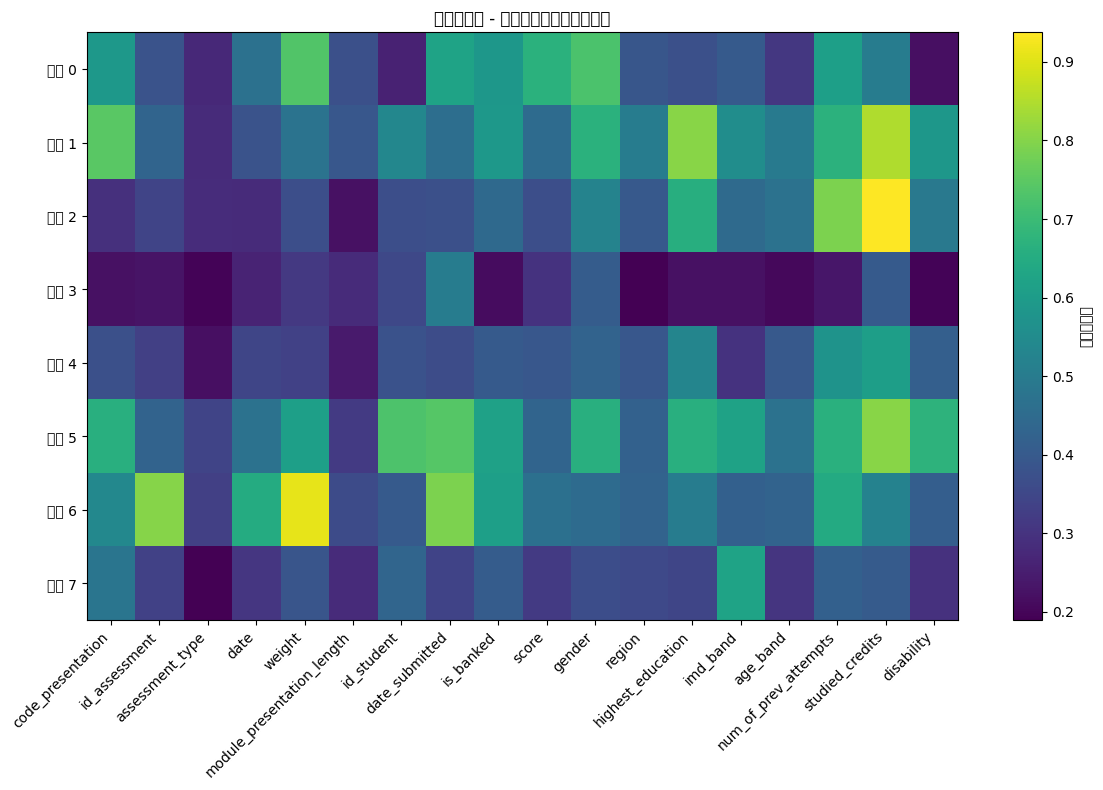

In [9]:
# # 对去偏见模型也做同样的分析
# print("特征重要性分析（去偏见模型）：")
# feature_importance_debiased = debiased_model.get_feature_importance(dataset_orig_train)

# # 排序并可视化
# sorted_importance_debiased = sorted(feature_importance_debiased, key=lambda x: x[1], reverse=True)
# feature_names_debiased = [x[0] for x in sorted_importance_debiased]
# importance_values_debiased = [x[1] for x in sorted_importance_debiased]

# plt.figure(figsize=(10, 6))
# plt.barh(feature_names_debiased, importance_values_debiased)
# plt.xlabel('重要性分数')
# plt.ylabel('特征')
# plt.title('特征重要性（去偏见模型）')
# plt.tight_layout()
# plt.show()

# 可视化每个专家网络对每个特征的活跃程度
def visualize_expert_importance(model, dataset, title):
    import numpy as np 
    expert_importance = model.analyze_expert_weights()
    feature_names = dataset.feature_names
    
    if not expert_importance or not any(expert_importance):
        print(f"警告：无法获取{title}的专家网络重要性")
        return
    
    # 只使用第一层权重分析特征重要性
    expert_first_layer = []
    for expert_id, expert_layers in enumerate(expert_importance):
        if expert_layers:
            expert_first_layer.append(expert_layers[0])
        else:
            # 如果该专家没有权重，用零填充
            expert_first_layer.append(np.zeros(len(feature_names)))
    
    # 创建热图
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    im = ax.imshow(expert_first_layer, aspect='auto', cmap='viridis')
    
    # 设置坐标轴
    ax.set_xticks(np.arange(len(feature_names)))
    ax.set_yticks(np.arange(len(expert_importance)))
    ax.set_xticklabels(feature_names, rotation=45, ha='right')
    ax.set_yticklabels([f'专家 {i}' for i in range(len(expert_importance))])
    
    # 添加颜色条
    plt.colorbar(im, ax=ax, label='特征重要性')
    
    # 设置标题和标签
    plt.title(f'{title} - 专家网络特征重要性热图')
    plt.tight_layout()
    plt.show()

# 可视化两个模型的专家网络特征重要性
visualize_expert_importance(debiased_model, dataset_orig_train, "去偏见模型")

In [10]:
# # 去偏见的模型数据集的度量指标
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())




display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)

print("Test set: Statistical parity difference = %f" % classified_metric_debiasing_test.statistical_parity_difference())
print("Test set: Equalized Odds difference = %f" % classified_metric_debiasing_test.equalized_odds_difference())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())

#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.017127
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.012201


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.669373
Test set: Statistical parity difference = -0.012201
Test set: Equalized Odds difference = 0.004819
Test set: Equal opportunity difference = 0.000000
Test set: Disparate impact = 0.984713
